http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz

In [1]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

(1008,)
images/car.jpg


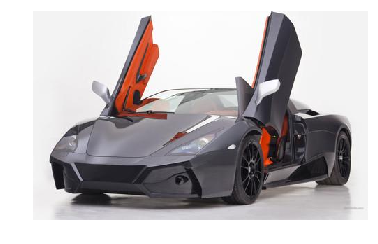

sports car, sport car (score = 0.92857)
convertible (score = 0.01096)
racer, race car, racing car (score = 0.01036)
chain saw, chainsaw (score = 0.00356)
car wheel (score = 0.00301)

(1008,)
images/cat.jpg


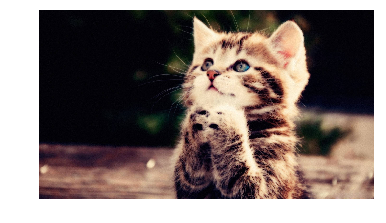

Egyptian cat (score = 0.56963)
tabby, tabby cat (score = 0.23580)
tiger cat (score = 0.07601)
lynx, catamount (score = 0.06609)
hyena, hyaena (score = 0.00296)

(1008,)
images/dog.jpg


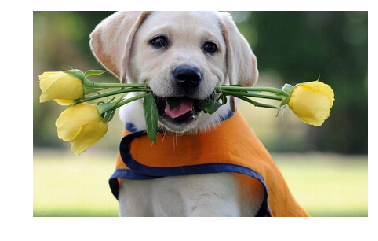

Labrador retriever (score = 0.95146)
golden retriever (score = 0.02061)
tennis ball (score = 0.00399)
beagle (score = 0.00093)
Saluki, gazelle hound (score = 0.00070)

(1008,)
images/flower.jpg


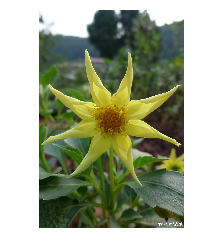

daisy (score = 0.84465)
pot, flowerpot (score = 0.00774)
bee (score = 0.00677)
grasshopper, hopper (score = 0.00376)
earthstar (score = 0.00290)

(1008,)
images/mouse.jpg


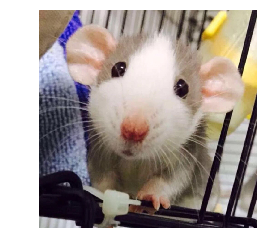

hamster (score = 0.85329)
guinea pig, Cavia cobaya (score = 0.00653)
syringe (score = 0.00262)
screwdriver (score = 0.00199)
broccoli (score = 0.00189)

(1008,)
images/plane.jpg


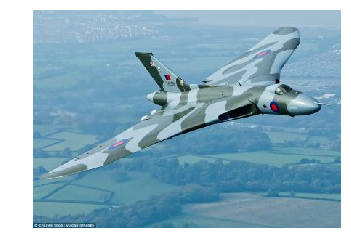

warplane, military plane (score = 0.80952)
wing (score = 0.06407)
aircraft carrier, carrier, flattop, attack aircraft carrier (score = 0.01055)
projectile, missile (score = 0.01019)
missile (score = 0.00886)

(1008,)
images/seaside.jpg


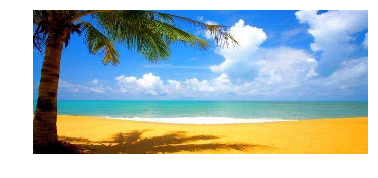

seashore, coast, seacoast, sea-coast (score = 0.86162)
sandbar, sand bar (score = 0.08214)
lakeside, lakeshore (score = 0.02578)
sarong (score = 0.00675)
coral reef (score = 0.00383)



In [2]:
class NodeLookup(object):
    def __init__(self):  
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'   
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符串n********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}
        
        # 一行一行读取数据
        for line in proto_as_ascii_lines :
            # 去掉换行符
            line=line.strip('\n')
            # 按照'\t'分割
            parsed_items = line.split('\t')
            # 获取分类编号
            uid = parsed_items[0]
            # 获取分类名称
            human_string = parsed_items[1]
            # 保存编号字符串n********与分类名称映射关系 “键值对”
            uid_to_human[uid] = human_string

        # 加载分类字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        # 定义一个空的字典
        node_id_to_uid = {}
        for line in proto_as_ascii:
            # 去掉换行符
            line=line.strip('\n')
            # 以target_class开头
            if line.startswith('  target_class:'):
                # 获取分类编号1-1000
                target_class = int(line.split(': ')[1])
            if line.startswith('  target_class_string:'):
                # 获取编号字符串n********
                target_class_string = line.split(': ')[1]
                # 保存分类编号1-1000与编号字符串n********映射关系 "键值对"
                node_id_to_uid[target_class] = target_class_string[1:-1]

        # 建立分类编号1-1000对应分类名称的映射关系
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            # 获取分类名称
            name = uid_to_human[val]
            # 建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name
        return node_id_to_name

    # 传入分类编号1-1000返回分类名称
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]


# 创建一个图来存放google训练好的模型
with tf.gfile.GFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')


with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    # 遍历目录
    for root,dirs,files in os.walk('images/'):
        for file in files:
            # 载入图片
            image_data = tf.gfile.GFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0': image_data}) # 图片格式是jpg格式
            predictions = np.squeeze(predictions) # 把结果转为1维数据
            # [[0.01,0.02,...]]
            print(predictions.shape) # 1008个种类


            # 打印图片路径及名称
            image_path = os.path.join(root,file)
            print(image_path)
            # 显示图片
            img=Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            # 排序:升序
            top_k = predictions.argsort()[-5:][::-1] # 取最后五个较大的值
            node_lookup = NodeLookup()
            for node_id in top_k:     
                # 获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                # 获取该分类的置信度
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))
            print()